# Text Classification for Topic Modelling

## Notebook Imports

In [1]:
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

# Other
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
from nltk.corpus import wordnet
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Data Loading

In [4]:
DATASET_ROOT = '/kaggle/input/topic-modeling-for-research-articles/Train.csv'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_df = pd.read_csv(DATASET_ROOT)
train_df.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing

In [6]:
# Dropping ID
train_df.drop('id', axis=1, inplace=True)

# Resetting ID 
train_df.reset_index()

topics = train_df.columns[1:]
train_df['Target'] = train_df[topics].idxmax(axis=1)
train_df.drop(topics, axis=1, inplace=True)
train_df.head()

,ABSTRACT,Target
0,a ever-growing datasets inside observational a...,Physics
1,we propose the framework considering optimal $...,Computer Science
2,nanostructures with open shell transition meta...,Physics
3,stars are self-gravitating fluids inside which...,Physics
4,deep neural perception and control networks ar...,Computer Science


In [7]:
encoder = LabelEncoder()
train_df['Target_Label'] = encoder.fit_transform(train_df['Target'])

In [8]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer(), ml=True) -> list:
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    if ml:
        preprocessed_text = ' '.join(preprocessed_text)
    
    return preprocessed_text

In [9]:
preprocessed_text_dl = train_df.ABSTRACT.apply(preprocess_text, ml=False)
preprocessed_text_ml = train_df.ABSTRACT.apply(preprocess_text)

In [10]:
train_df['Preprocessed Text ML'] = preprocessed_text_ml
train_df['Preprocessed Text DL'] = preprocessed_text_dl
train_df.drop('ABSTRACT', axis=1, inplace=True)
train_df.head()

,Target,Target_Label,Preprocessed Text ML,Preprocessed Text DL
0,Physics,2,datasets inside observational astronomy challe...,"[datasets, inside, observational, astronomy, c..."
1,Computer Science,0,propose framework considering optimal excludin...,"[propose, framework, considering, optimal, exc..."
2,Physics,2,nanostructures open shell transition metal mol...,"[nanostructures, open, shell, transition, meta..."
3,Physics,2,star fluid inside pressure buoyancy rotation m...,"[star, fluid, inside, pressure, buoyancy, rota..."
4,Computer Science,0,deep neural perception control network likely ...,"[deep, neural, perception, control, network, l..."


### Building Vocabulary and Encoding Text

In [11]:
# Build vocabulary
vocab = build_vocab_from_iterator(preprocessed_text_dl, specials=["<pad>", "<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

# Convert tokens to indices
def encode(text):
    return [vocab[token] for token in text]

encoded_data = [encode(text) for text in preprocessed_text_dl]

In [12]:
text_data = pad_sequence([torch.tensor(seq) for seq in encoded_data], batch_first=True, padding_value=vocab['<pad>'])
train_df['Encoded & Padded Text'] = text_data.tolist()
train_df.head()

,Target,Target_Label,Preprocessed Text ML,Preprocessed Text DL,Encoded & Padded Text
0,Physics,2,datasets inside observational astronomy challe...,"[datasets, inside, observational, astronomy, c...","[140, 2, 1087, 2624, 7251, 3218, 2, 91, 725, 1..."
1,Computer Science,0,propose framework considering optimal excludin...,"[propose, framework, considering, optimal, exc...","[33, 57, 3, 112, 6777, 2771, 2, 2581, 68, 22, ..."
2,Physics,2,nanostructures open shell transition metal mol...,"[nanostructures, open, shell, transition, meta...","[6594, 474, 2427, 144, 917, 769, 3430, 765, 23..."
3,Physics,2,star fluid inside pressure buoyancy rotation m...,"[star, fluid, inside, pressure, buoyancy, rota...","[126, 712, 2, 577, 6052, 899, 85, 39, 69, 7144..."
4,Computer Science,0,deep neural perception control network likely ...,"[deep, neural, perception, control, network, l...","[54, 49, 1674, 77, 7, 891, 295, 172, 503, 4, 3..."


### Balancing an Imbalanced Dataset 

In [13]:
ros = RandomOverSampler(random_state=42)
X_balanced_ml, y_balanced_ml = ros.fit_resample(train_df[['Preprocessed Text ML']], train_df[['Target']])

In [14]:
balanced_dict = {
    'Preprocessed Text': X_balanced_ml.squeeze(),
    'Target': y_balanced_ml.squeeze()
}

balanced_df_ml = pd.DataFrame(balanced_dict)
balanced_df_ml = balanced_df_ml.sample(n=len(balanced_df_ml)).reset_index(drop=True)
balanced_df_ml.head()

,Preprocessed Text,Target
0,paper proposes new general methodology conside...,Mathematics
1,derive detailed asymptotic expansion heat trac...,Mathematics
2,considering balanced wall crossing inside geom...,Mathematics
3,define distance edge graph study coarse ricci ...,Mathematics
4,potential positive impact autonomous driving d...,Computer Science


In [15]:
X_balanced_dl, y_balanced_dl = ros.fit_resample(train_df[['Encoded & Padded Text']], train_df[['Target_Label']])

balanced_dict = {
    'Preprocessed Text': X_balanced_dl.squeeze(),
    'Target': y_balanced_dl.squeeze()
}

balanced_df_dl = pd.DataFrame(balanced_dict)
balanced_df_dl = balanced_df_dl.sample(n=len(balanced_df_dl)).reset_index(drop=True)
balanced_df_dl.head()

,Preprocessed Text,Target
0,"[2566, 264, 618, 514, 383, 42, 3, 136, 251, 90...",0
1,"[16233, 2279, 23, 286, 206, 24, 25, 5, 3540, 1...",3
2,"[428, 844, 2544, 2, 1192, 206, 14, 582, 512, 5...",0
3,"[33, 180, 3, 1468, 67, 2, 252, 7, 190, 1098, 1...",0
4,"[721, 89, 100, 971, 132, 4398, 261, 588, 13433...",1


In [16]:
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

counts = count_vect.fit_transform(balanced_df_ml['Preprocessed Text'])
tfidf = transformer.fit_transform(counts)

# Data Visualization

<Axes: xlabel='Target', ylabel='count'>

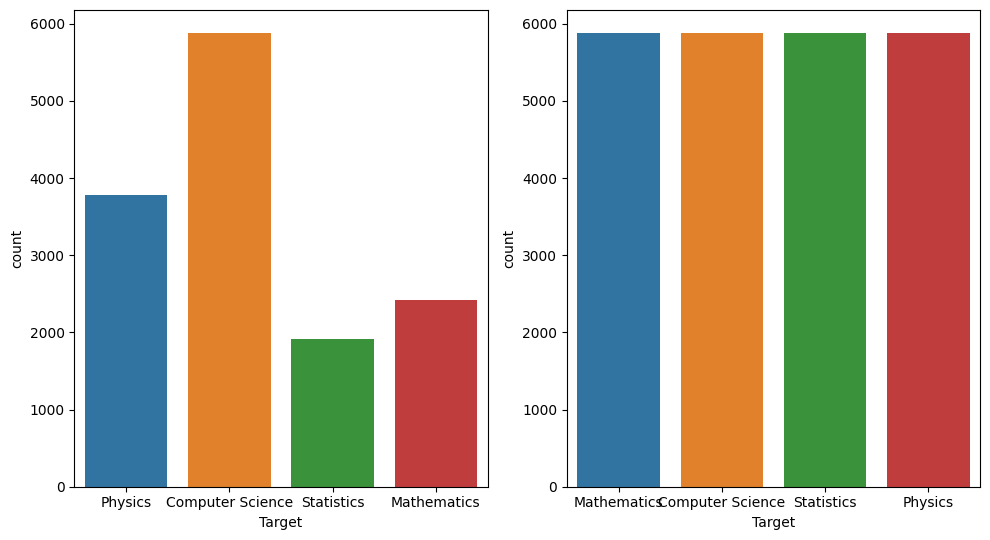

In [17]:
plt.rcParams["figure.figsize"] = [10.00, 5.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.countplot(data=train_df, x='Target', ax=axes[0])
sns.countplot(data=balanced_df_ml, x='Target', ax=axes[1])

# Machine Learning with Scikit Learn

In [18]:
LABELS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(tfidf, balanced_df_ml['Target'], 
                                                    test_size=0.2, random_state=42)

In [20]:
def model_training(model, x_train, y_train, x_test, y_test):
    
    model = model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

In [21]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

## Logistic Regression

In [22]:
lr = LogisticRegression(C=1, max_iter=1000, n_jobs=-1, solver='newton-cg')
y_pred_lr = model_training(model=lr, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
accuracy_score(y_test,y_pred_lr)

0.9243840271877655

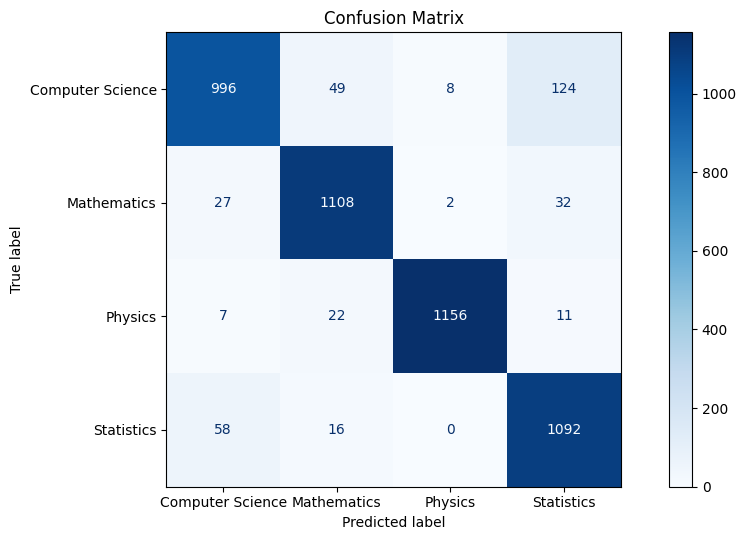

In [23]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

In [24]:
print(classification_report(y_test, y_pred_lr))

                  precision    recall  f1-score   support

Computer Science       0.92      0.85      0.88      1177
     Mathematics       0.93      0.95      0.94      1169
         Physics       0.99      0.97      0.98      1196
      Statistics       0.87      0.94      0.90      1166

        accuracy                           0.92      4708
       macro avg       0.93      0.92      0.92      4708
    weighted avg       0.93      0.92      0.92      4708



## Multinomial Naive Bayes

In [25]:
nb = MultinomialNB(alpha=0.8)
y_pred_nb = model_training(model=nb, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
accuracy_score(y_test,y_pred_nb)

0.8795666949872557

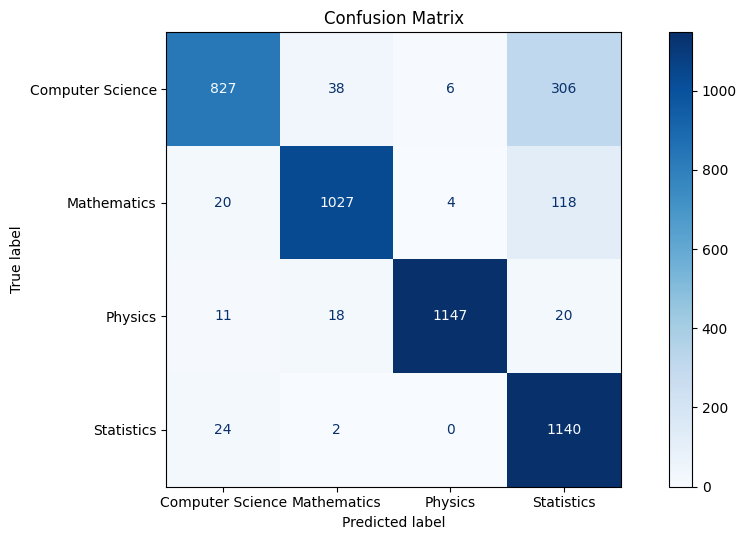

In [26]:
plot_confusion_matrix(y_test, y_pred_nb, LABELS)

In [27]:
print(classification_report(y_test, y_pred_nb, zero_division=0))

                  precision    recall  f1-score   support

Computer Science       0.94      0.70      0.80      1177
     Mathematics       0.95      0.88      0.91      1169
         Physics       0.99      0.96      0.97      1196
      Statistics       0.72      0.98      0.83      1166

        accuracy                           0.88      4708
       macro avg       0.90      0.88      0.88      4708
    weighted avg       0.90      0.88      0.88      4708



# Deep Learning with PyTorch

## Model Building

In [28]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [29]:
text_data = torch.tensor(balanced_df_dl['Preprocessed Text'].values.tolist())
target = torch.tensor(balanced_df_dl['Target'].values)
X, y = text_data, target

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [31]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [33]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, input_length):
        super(TextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=input_length)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=embed_dim, dropout=0.5, 
                            bidirectional=True, batch_first=True, num_layers=2)
        self.linear = nn.Linear(in_features=embed_dim * 2, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        output = self.linear(hidden)
        return output

In [34]:
# Hyperparameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 4
INPUT_LENGTH = text_data.shape[1]

EPOCHS = 10

In [35]:
model = TextClassifier(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, 
                       hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, input_length=INPUT_LENGTH).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [36]:
model

TextClassifier(
  (embedding): Embedding(20534, 100, padding_idx=401)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=200, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Model Training

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(EPOCHS):
    model.train()
    
    for texts, labels in train_loader:
        output_logits = model(texts)
        output = torch.softmax(output_logits, dim=1).argmax(dim=1)
        loss = loss_fn(output_logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

/tmp/ipykernel_24/1367531656.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


Epoch [1/10], Loss: 0.9656
Epoch [2/10], Loss: 0.6912
Epoch [3/10], Loss: 0.7651
Epoch [4/10], Loss: 0.6409
Epoch [5/10], Loss: 0.6443
Epoch [6/10], Loss: 0.5534
Epoch [7/10], Loss: 0.4847
Epoch [8/10], Loss: 0.5320
Epoch [9/10], Loss: 0.4776
Epoch [10/10], Loss: 0.5054


## Model Testing

In [38]:
model.eval()
with torch.inference_mode():
    for texts, labels in test_loader:
        output_logits = model(texts)
        output = torch.softmax(output_logits, dim=1).argmax(dim=1)

/tmp/ipykernel_24/1367531656.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


## Evaluation

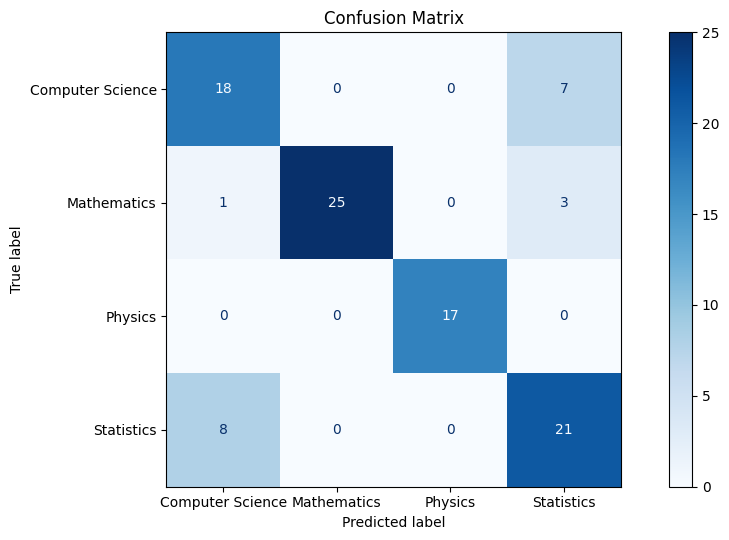

In [39]:
plot_confusion_matrix(labels.to('cpu'), output.to('cpu'), LABELS)

In [40]:
print(classification_report(labels.to('cpu'), output.to('cpu')))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        25
           1       1.00      0.86      0.93        29
           2       1.00      1.00      1.00        17
           3       0.68      0.72      0.70        29

    accuracy                           0.81       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.82      0.81      0.81       100

